# Coherence Resonance in a Noise-Driven Excitable System

External noise has a direct impact on a dynamical system and, in response, it can show a large range of behaviours such as inducing order in chaotic dynamics, synchronization and stochastic resonance. We will study the **effect** of the **noise** on the autonomous excitable oscillator, **Fitz Hugh–Nagumo system**. 

The Fitz Hugh-Nagumo model describes the dynamics of excitable systems, such as kinetics of chemical reactions, solid-state physics and biological processes. It was developed by Richard Fitz Hugh and J. Nagumo independently in the 1960s, and it was originally develop to explain the dynamics of neurons or cardiac cells. The Fitz Hugh-Nagumo model consists on a set of two coupled ordinary differential equations:

$$\begin{aligned}\varepsilon\frac{dx}{dt} & =x-\frac{x^{3}}{3}-y\\
\frac{dy}{dt} & =x+a+D\xi(t)
\end{aligned} \tag{1}$$

where $\varepsilon<<1$ is a small parameter, a determines the behaviour of the solution and $D$ is the amplitude of the external noise $\xi(t)$, which is assumed to be Gaussian, with zero mean and delta-correlated $\left\langle \xi(t)\xi\left(t^{\prime}\right)\right\rangle =\delta\left(t-t^{\prime}\right)$. For $|a|>1$ the system shows a **stable fixed point** and for $|a|<1$ a lymit cycle appears. Since the parameter $\varepsilon$ is assumed to be small, one can separate the dynamics of the system into **fast motion**, where only x changes and **slow motion**, where y changes. Thus, when the parameter a is slightly larger than 1, the perturbation can bring the system to the border of the slow branch on which the stable fixed point lies, and then the system will return to the stable fixed point following the slow branch, after a **large excursion**. So, the small deviations from the fixed point produce pulses. In this situation, we say that the system is excitable.

From here on, we assume $\varepsilon=0.01$ and $a=1.05$.

### Simulation

We need to use an algorithm to integrate numerically a Stochastic Differential Equation (SDE), since we are dealing stochastic noise. We will use the Heun's method for SDE, which is a modification of the Euler's method adapted to solve SDE with white noise.

First, we need to define the deterministic part of the Fitz Hugh-Nagumo model and the stochastic part.

In [2]:
import numpy as np
from numba import jit

In [3]:
@jit
def q(x):
    #Deterministic part of the SDE
    #We take a = 1.05 and epsilon = 0.01
    return np.array([(x[0] - x[0]**3 / 3 - x[1])*100, x[0] + 1.05])

In [4]:
@jit
def g(D):

    #Noise part of the SDE
    return np.array([0, D])

Now, we can define the Heun's algorithm:

In [5]:
@jit
def heun(t0, tf, x0, h, D, inner_steps):
    '''
    Heun algorithm to integrate numerically a SDE with a white noise
    and two variables

        t0, tf, x0 :    Initial conditions of the problem
        h :             time increase
        D :             strength of the noise
        inner_steps :   number of steps between two steps of storing data
    '''

    #Defining constants
    delta_t = h*inner_steps
    num_steps = int((tf - t0) / (delta_t)) + 1

    #Time
    t = np.linspace(t0, tf, num_steps)

    #Array to store the x-values
    x = np.zeros((num_steps, 2))
    x[0] = x0

    #Constants needed for the algorithm
    h_sqrt = np.sqrt(h)

    #Loop over storing data
    for i in range(num_steps):

        #Auxiliary variable to compute the intermediate values
        x_j = x[i]

        #Inner loop doing "inner_steps" steps between writing
        for _ in range(inner_steps):

            #Constants
            u = np.random.normal()
            k = h*q(x_j)
            l = g(D)*h_sqrt*u
            x_j += 0.5*h*(q(x_j) + q(x_j + k + l)) + l

        x[i+1] = x_j

    return t, x

We are ready to solve the stochastic differential equations

In [6]:
import matplotlib.pyplot as plt

### Dynamics

First, we are going to see the phase space of the Fitz Hugh Nagumo model (y vs x)

In [7]:
#Constants
t0 = 0
tf = 5
x0 = np.array([0, 0])
h = 0.0005
D_values = [0, 0.02]   #Without noise and small noise
inner_steps = 10

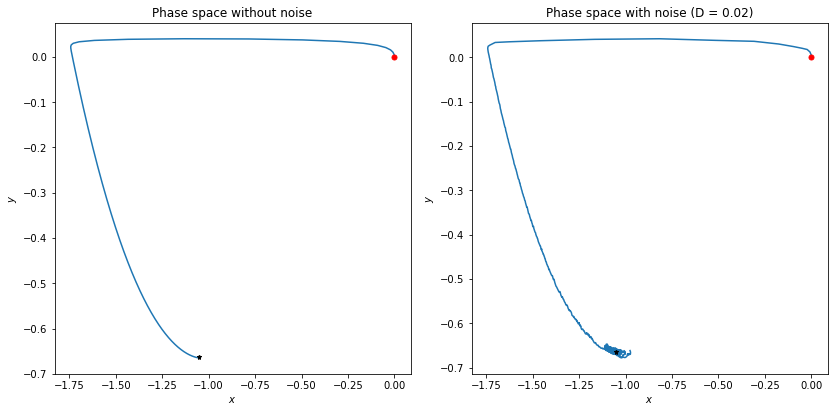

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
fig.tight_layout(pad=3.0)

titles = ['Phase space without noise', 'Phase space with noise (D = 0.02)']

for i, D in enumerate(D_values):

    axes[i].set_xlabel("$x$")
    axes[i].set_ylabel("$y$")
    axes[i].set_title(titles[i])
    
    t, x = heun(t0, tf, x0, h, D, inner_steps)
    axes[i].plot(x[:,0], x[:,1])
    axes[i].plot(-1.05, -0.664, 'k*', markersize = 5)   #Fixed point
    axes[i].plot(0, 0, 'ro', markersize = 5)   #Initial position

plt.show()

We see that in the case without noise (left) the trajectory falls into the stable fixed point $\left(-a,a-\frac{a^{3}}{3}\right)$ as we could expect. However, as we mentioned in the introduction, if we apply an external noise to the model (rigth), the trajectory can “escape” from the fixed point and follow a slow branch until it returns again to the fixed point, after a long excursion. To visualize the excitation we can take a look to only the dynamics of the variable y. 

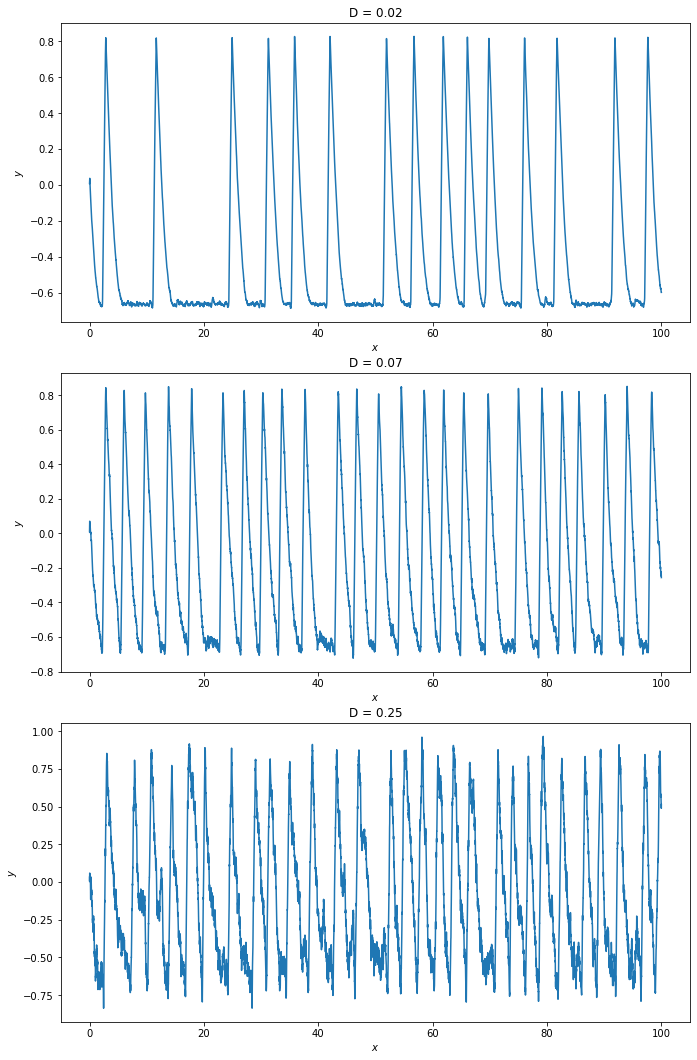

In [13]:
#Constants
t0 = 0
tf = 100
x0 = np.array([0, 0])
h = 0.001
D_values = [0.02, 0.07, 0.25]   #Without noise and small noise
inner_steps = 10

fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (10,15))
fig.tight_layout(pad=3.0)

for i, D in enumerate(D_values):

    axes[i].set_xlabel("$x$")
    axes[i].set_ylabel("$y$")
    axes[i].set_title(f'D = {D}')
    
    t, x = heun(t0, tf, x0, h, D, inner_steps)
    axes[i].plot(t, x[:,1])

We can observe a particularly interesting behaviour: for **small** and **large** noise amplitudes, the noise-excited oscillations are quite **irregular** between them, whereas at an **intermediate strength** ($D=0.07$) the pulses appear to be more **regular** and **correlated**. This phenomenon is usually known as **coherencen resonance**. Let's quantify this behaviour. 

### The autocorrelation function

It would appear that for intermediate noise amplitudes, the pulses tend to be more regular and correlated. To characterize this phenomena quantitatively, we compute the **normalized autocorrelation function**:

$$C(\tau)=\frac{\langle\tilde{y}(t)\tilde{y}(t+\tau)\rangle}{\left\langle \tilde{y}^{2}\right\rangle },\quad\tilde{y}=y-\langle y\rangle \tag{2}$$

where $\tau$ is the time separation between in the time interval. We will consider the mean $\langle y\rangle$ as the mean over a long trajectory ($t>10^{4}$)



In [14]:
@jit
def get_autocorrelation(t_long, s0, sf, delta_s, x0, h, D, inner_steps):

    '''
    A function to calculate the autocorrelation function C(s)
    over a long trajectory

        t_long :        the value of time of the long trajectory
        s0, sf :        time interval of the variable s
        delta_s :       time step between two consecutives values of s
        x0, h, D,
        inner_steps:  variables of the Heun algorithm
    
    '''

    #Number of steps
    num_steps = int((sf - s0) / delta_s) + 1

    #The jump in index of x(t) between two consecutive
    # steps, assuming delta_s jumps 
    index_steps = int(delta_s / (h*inner_steps))

    #Array to store s and the correlation function
    s = np.linspace(s0, sf, num_steps)
    corr_s = np.zeros(num_steps)

    t, x = heun(0, t_long + sf, x0, h, D, inner_steps)
    
    y_hat = x[:, 1] - np.mean(x[:, 1])

    #Loop over the number of steps in s
    for i in range(num_steps):

        corr_s_i = 0

        #Loop over the times of the long trajectory
        for j in range(len(t) - index_steps*num_steps):

            corr_s_i += y_hat[j]*y_hat[j + i*index_steps]

        #Average of the long trajectory
        corr_s[i] = corr_s_i/(len(t) - index_steps*num_steps)

    #Normalization with the variance
    return s, corr_s/corr_s[0], t, x[:,1]

In [18]:
#Constants
t_long = 100000   #Long trajectory
s0 = 0
sf = 50
delta_s = 0.1
x0 = np.array([0,0])
h = 0.001
D = 0.25
inner_steps = 10

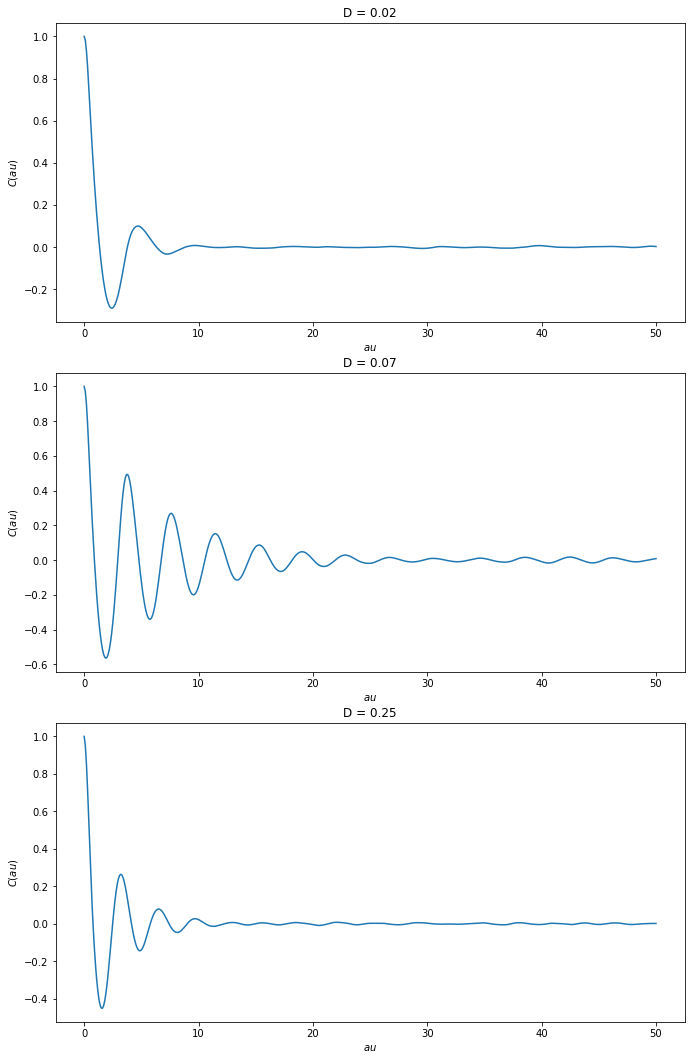

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (10,15))
fig.tight_layout(pad=3.0)

for i, D in enumerate(D_values):

    axes[i].set_xlabel("$\tau$")
    axes[i].set_ylabel("$C(\tau)$")
    axes[i].set_title(f'D = {D}')
    
    s, corr, t, y = get_autocorrelation(t_long, s0, sf, delta_s, x0, h, D, inner_steps)
    axes[i].plot(s, corr)

We see that, in fact, the autocorrelation of a trajectory is larger for an intermediate noise amplitude.

### Correlation time and noise-to-signal ratio

To quantify all previous findings in a single quantity we can calculate the **correlation time** of the pulses as

$$\tau_{c}=\int_{0}^{\infty}C^{2}(t)dt\simeq\int_{0}^{t_{f}}C^{2}(t)dt \tag{3} $$

where we have approximate the infinite integral with $t_{f}$ as we cannot compute numerically an infinite integral. Still, it is a very good approximation as we see that for t>50, the autocorrelation function is almost zero. 

Before showing the results of the correlation time, we present another quantity which is known as noise-to-signal ratio. We have seen that the process can be viewed as a sequence of pulses with a certain duration, $t_{p}$. We define the duration of a pulse as the distance between two consecutive maximums. Thus, we define the **noise-to-signal ratio** as the normalized fluctuations of pulse durations:

$$R_{p}=\frac{\sqrt{Var}(t_{p})}{\langle t_{p}\rangle} \tag{4}$$

In [19]:
from scipy.signal import argrelextrema  #Function to calculate the maximums

In [20]:
def get_tp(t, y):

    '''
    A function to calculate the duration of the pulses, given the
    time and the values of y.

    '''

    #Calculating the value of the maximum
    max_values = y[argrelextrema(y, np.greater)[0]]
    max_values = max_values[max_values>0.5]

    t_max = np.zeros(0)

    previous_max = -10

    #Loop over maximum
    for max_val in max_values:

        #Time where the maximum is located
        a = t[np.where(max_val == y)]

        #Due to fluctuations, there are local maximum
        #that are not "real maximum" (we do not count them)
        if a - previous_max >1:
            t_max = np.append(t_max, a)
            previous_max = a

    #Difference between the maximum
    t_p = np.diff(t_max)

    return t_p

In [26]:
#Constants
t_long = 10000  #Long trajectory
s0 = 0
sf = 50
delta_s = 0.1
x0 = np.array([0,0])
h = 0.001
D_values = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.15, 0.25, 0.3]
inner_steps = 10

In [27]:
from scipy.interpolate import InterpolatedUnivariateSpline  #To interpolate a set of points

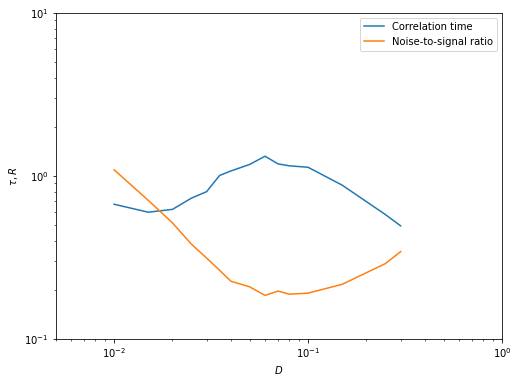

In [28]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(xlim=(0.005, 1), ylim=(0.1, 10))

ax.set_xlabel("$D$")
ax.set_ylabel(r"$\tau, R $")

ax.set_xscale('log')
ax.set_yscale('log')

#List to store the autocorrelation time and R
r = []
corr_time = []

#Loop over different values of D
for D in D_values:

    #Autocorrelation function
    s, corr, t, y = get_autocorrelation(t_long, s0, sf, delta_s, x0, h, D, inner_steps)

    #Interpolating and integrating C(s)^2
    f = InterpolatedUnivariateSpline(s, corr**2, k=1)
    corr_time.append(f.integral(0,50))

    #Calculating R
    tp = get_tp(t, y)
    r.append(np.std(tp) / np.mean(tp))

ax.plot(D_values, corr_time, label = 'Correlation time' )
ax.plot(D_values, r, label = 'Noise-to-signal ratio')
ax.legend()

plt.show()

We observe that the maximum in the correlation time occurs at $D_{res}\simeq0.06$ and the minimum of the noise-to-signal ratio at the same value. (Increase the duration of the long trajectory for better results !!!)

The duration of a pulse is the sum of two contributions: the activation time, $t_{a}$, and the excursion time, $t_{e}$. Thus, $t_{p}=t_{a}+t_{e}$. The activation time is the time needed to excite the system from the fixed point, and the excursion time is the time needed to return to the stable fixed point. The dependence with the noise of these two contributions is different. The activation time decreases rapidly with the noise amplitude so, for a large external noise, the excursion time dominates the duration of the pulse. In contrary, for small noise amplitudes, the activation time is much bigger than the excursion time. In the maximum of R, the noise amplitude is sufficiently large that $t_{a}<<t_{e}$ , but not very large so that fluctuations of the excursion time are small.

### Model of the coherence resonance

Allong one of the lines of slow motion (due to the parameter $\varepsilon$) the dynamics can be reduced to the one dimensional Langevin equation (see reference [])

$$\frac{dy}{dt}=-\frac{dU}{dy}+D\xi(t) \tag{5} $$

where $U(y)$ is a potential. It can be proven that the equations of the first two moments are given by

$$\left\langle t_{p}\left(y_{0}\right)\right\rangle =\frac{2}{D^{2}}\int_{y_{0}}^{0}dv\int_{-\infty}^{v}du\exp\left(2\frac{U(v)-U(u)}{D^{2}}\right) \tag{6} $$
$$ \left\langle t_{p}^{2}\left(y_{0}\right)\right\rangle =\frac{4}{D^{2}}\int_{y_{0}}^{0}dv\int_{-\infty}^{v}du\langle t_{p}(y_{0})\rangle\exp\left(2\frac{U(v)-U(u)}{D^{2}}\right) \tag{7} $$

In order to get an analytical value of R to characterize the coherence of the oscillations we propose a simple potential: $U(y)=-y$ if $y<-1$ and $U(y)=2+y$ if $0>y>-1$. The integration of (6) and (7) using this potential leads us to 

$$ \left\langle t_{p}\left(y_{0}\right)\right\rangle = -(y_{0}+1)+\frac{D^{2}}{4}(e^{4/D^{2}}-1) \tag{8} $$
$$ \left\langle t_{p}^{2}\left(y_{0}\right)\right\rangle = \frac{D^{2}}{2}(e^{4/D^{2}}-1)\langle t_{p}(y_{0})\rangle+y_{0}^{2}-(D^{2}-2)y_{0}-D^{2}+1+\frac{D^{2}}{8}\left((3D^{2}-4)e^{4/D^{2}}-3D^{2}\right) \tag{9} $$

In [31]:
def first_moment(D, y0):

    #First moment of t_p
    return 2*(0.125*(D**4)*(np.exp(4/(D**2)) - 1) - (y0+1)*(D**2)/2)/D**2

In [32]:
def second_moment(D, y0):

    #Second moment of t_p
    a = (0.5*D**2)*(np.exp(4/D**2))*first_moment(D, y0)
    b = y0**2 - (D**2 - 2)*y0 -D**2 + 1
    c = (3*D**2 - 4)*np.exp(4/D**2) - 3*D**2

    return a + b + (0.125*D**2)*c

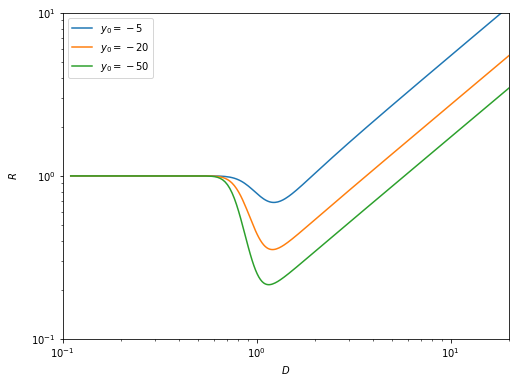

In [34]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(xlim=(0.1, 20), ylim=(0.1, 10))

ax.set_xlabel("$D$")
ax.set_ylabel(r"$R $", labelpad=12.0)

ax.set_xscale('log')
ax.set_yscale('log')

y0_list = [-5, -20, -50]
D_values = np.linspace(0.11, 20, 1000)

#Loops over values of y0 and D
for y0 in y0_list:

    r = []

    for D in D_values:

        #sqrt(var[t_p]) / <t_p>
        r.append(np.sqrt(second_moment(D, y0) -first_moment(D, y0)**2) / first_moment(D, y0))

    ax.plot(D_values, np.array(r), label = f'$y_0 = {y0}$')

ax.legend()

#fig.savefig('r_analytical.png')
plt.show()

As we see, these analytical solutions are very similar to the ones obtained numerically, as we observe the minimum of the noise-to-signal ratio for an intermediate value of the noise amplitude.

In conclusion, we have shown that noise-induced excitable systems exhibit complex behaviour. The highest coherence of noise-triggered oscillations is achieved at a specific noise intensity, which is a result of the interplay between various statistical properties of activation and excursion times. Furthermore, we have put forward a simplified explanation of this phenomenon using one-dimensional Langevin phase dynamics.

### References

A. Pikovsky and J. Kurths, *Coherence Resonance in a Noise-Driven Excitable System*, Phys. Rev. Lett. 78, 775 (1997).